In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import re
import scanpy.external as sce
import sys
import warnings
import glob

In [2]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * M.mad()) | (
        np.median(M) + nmads * M.mad() < M
    )
    return outlier

In [3]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=300, frameon=True, vector_friendly=True, fontsize=10, figsize=(4,4),
                     color_map=None, format='pdf', facecolor=None, transparent=True, ipython_format='png2x')

sc.settings.figdir = "scRNA-seq/Redone22/Manuscript/MurineModel"

mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["ps.fonttype"] = 42

## Import

In [4]:
scrublet_thresh_dict = {'SCAF3038_TF': 0.23,
                        'SCAF3039_TB': 0.15
                       }

In [5]:
file_name_lst = ["SCAF3038_TF", "SCAF3039_TB"]
full_adata_lst = []

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="Variable names are not unique.")

    for file in file_name_lst:
        file_path = f"scRNA-seq/03_FilteredMatricesH5/{file}_CD45_filtered_feature_bc_matrix.h5"
        sample_adata = sc.read_10x_h5(file_path)
        sample_adata.var_names_make_unique()
        sample_adata.obs["Sample"] = file
        
        exp_per_doublet = 0.00076*sample_adata.n_obs/ 100
        print(16*"- ")
        print(file)
            
        print(f"Size: {sample_adata.n_obs}")
        print(f"Expected percentage: {exp_per_doublet*100}")

        sce.pp.scrublet(sample_adata, verbose=False, n_neighbors=None, use_approx_neighbors=False, threshold=scrublet_thresh_dict[file])

        try:
            print("Detected percentage:", sample_adata.obs.predicted_doublet.value_counts(True)[True]*100)
        except:
            print("Detected percentage: 0")
        #sce.pl.scrublet_score_distribution(sample_adata)

        full_adata_lst.append(sample_adata)

adata = full_adata_lst[0].concatenate(full_adata_lst[1:])
print(adata.obs['predicted_doublet'].value_counts())
adata = adata[~adata.obs["predicted_doublet"]]

- - - - - - - - - - - - - - - - 
SCAF3038_TF
Size: 3915
Expected percentage: 2.9754


/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected percentage: 2.80970625798212
- - - - - - - - - - - - - - - - 
SCAF3039_TB
Size: 4640
Expected percentage: 3.5264


/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected percentage: 2.3706896551724137
- - - - - - - - - - - - - - - - 
SCAF3040_aPDL1
Size: 4074
Expected percentage: 3.0962400000000003


/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Detected percentage: 3.0682376043200783
False    12284
True       345
Name: predicted_doublet, dtype: int64


/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


## Preprocessing

In [7]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

adata.var["mt"] = adata.var_names.str.startswith("mt-")
adata.var["ribo"] = adata.var_names.str.contains(("^Rp[sl]"))
adata.var["hb"] = adata.var_names.str.contains(("^Hb[^(P)]"))
adata.var["Gm42418"] = adata.var_names.str.fullmatch(("Gm42418"))
adata.var["CD45"] = adata.var_names.str.fullmatch("Ptprc")

In [8]:
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb", "Gm42418", "CD45"], percent_top=[50], log1p=True, inplace=True)

In [9]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 5)
    | is_outlier(adata, "log1p_n_genes_by_counts", 5)
    | is_outlier(adata, "pct_counts_in_top_50_genes", 5)
)
print(adata.obs.outlier.value_counts())
adata = adata[(~adata.obs.outlier)]

False    8116
True      219
Name: outlier, dtype: int64


/var/folders/bj/fj47mx516_gc9y60blmf_5yr0000gn/T/ipykernel_95464/430617275.py:3: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  outlier = (M < np.median(M) - nmads * M.mad()) | (
/var/folders/bj/fj47mx516_gc9y60blmf_5yr0000gn/T/ipykernel_95464/430617275.py:4: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  np.median(M) + nmads * M.mad() < M


/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  df[key] = c


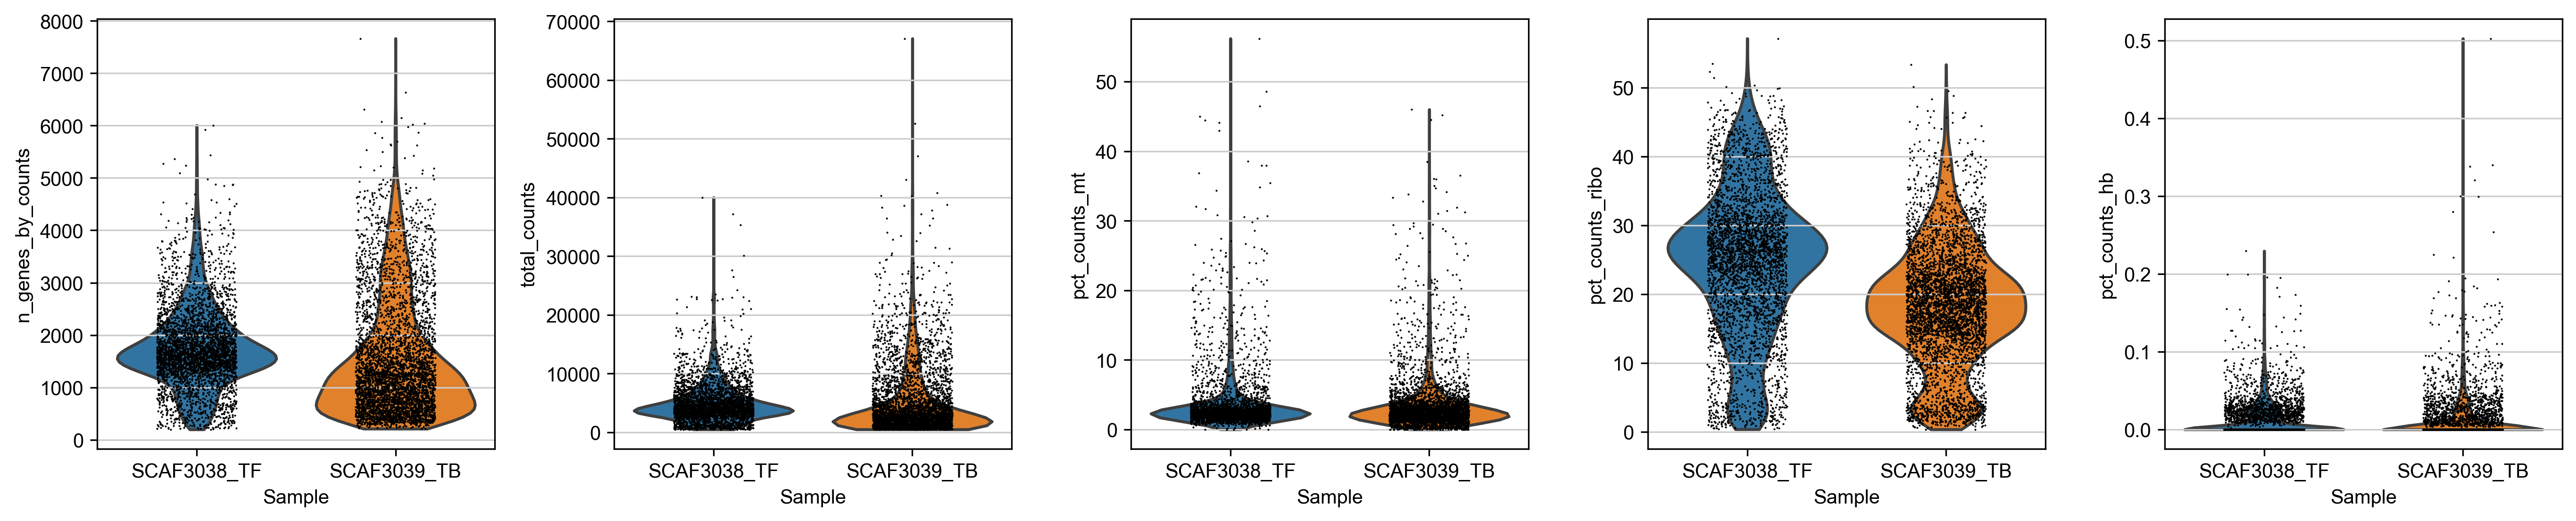

In [10]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', "pct_counts_ribo", "pct_counts_hb"], groupby="Sample",
             jitter=0.2, multi_panel=True)

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=20)

In [12]:
adata = adata[adata.obs['pct_counts_mt'] < 5]
print(f"Number of cells after MT filter: {adata.n_obs}.")

adata = adata[adata.obs['pct_counts_ribo'] > 12]
print('Number of cells after RIBO filter: {:d}'.format(adata.n_obs))

adata = adata[adata.obs["pct_counts_hb"] < 0.02, :]
print('Number of cells after HB filter: {:d}'.format(adata.n_obs))

Number of cells after MT filter: 7096.
Number of cells after RIBO filter: 6315
Number of cells after HB filter: 5005


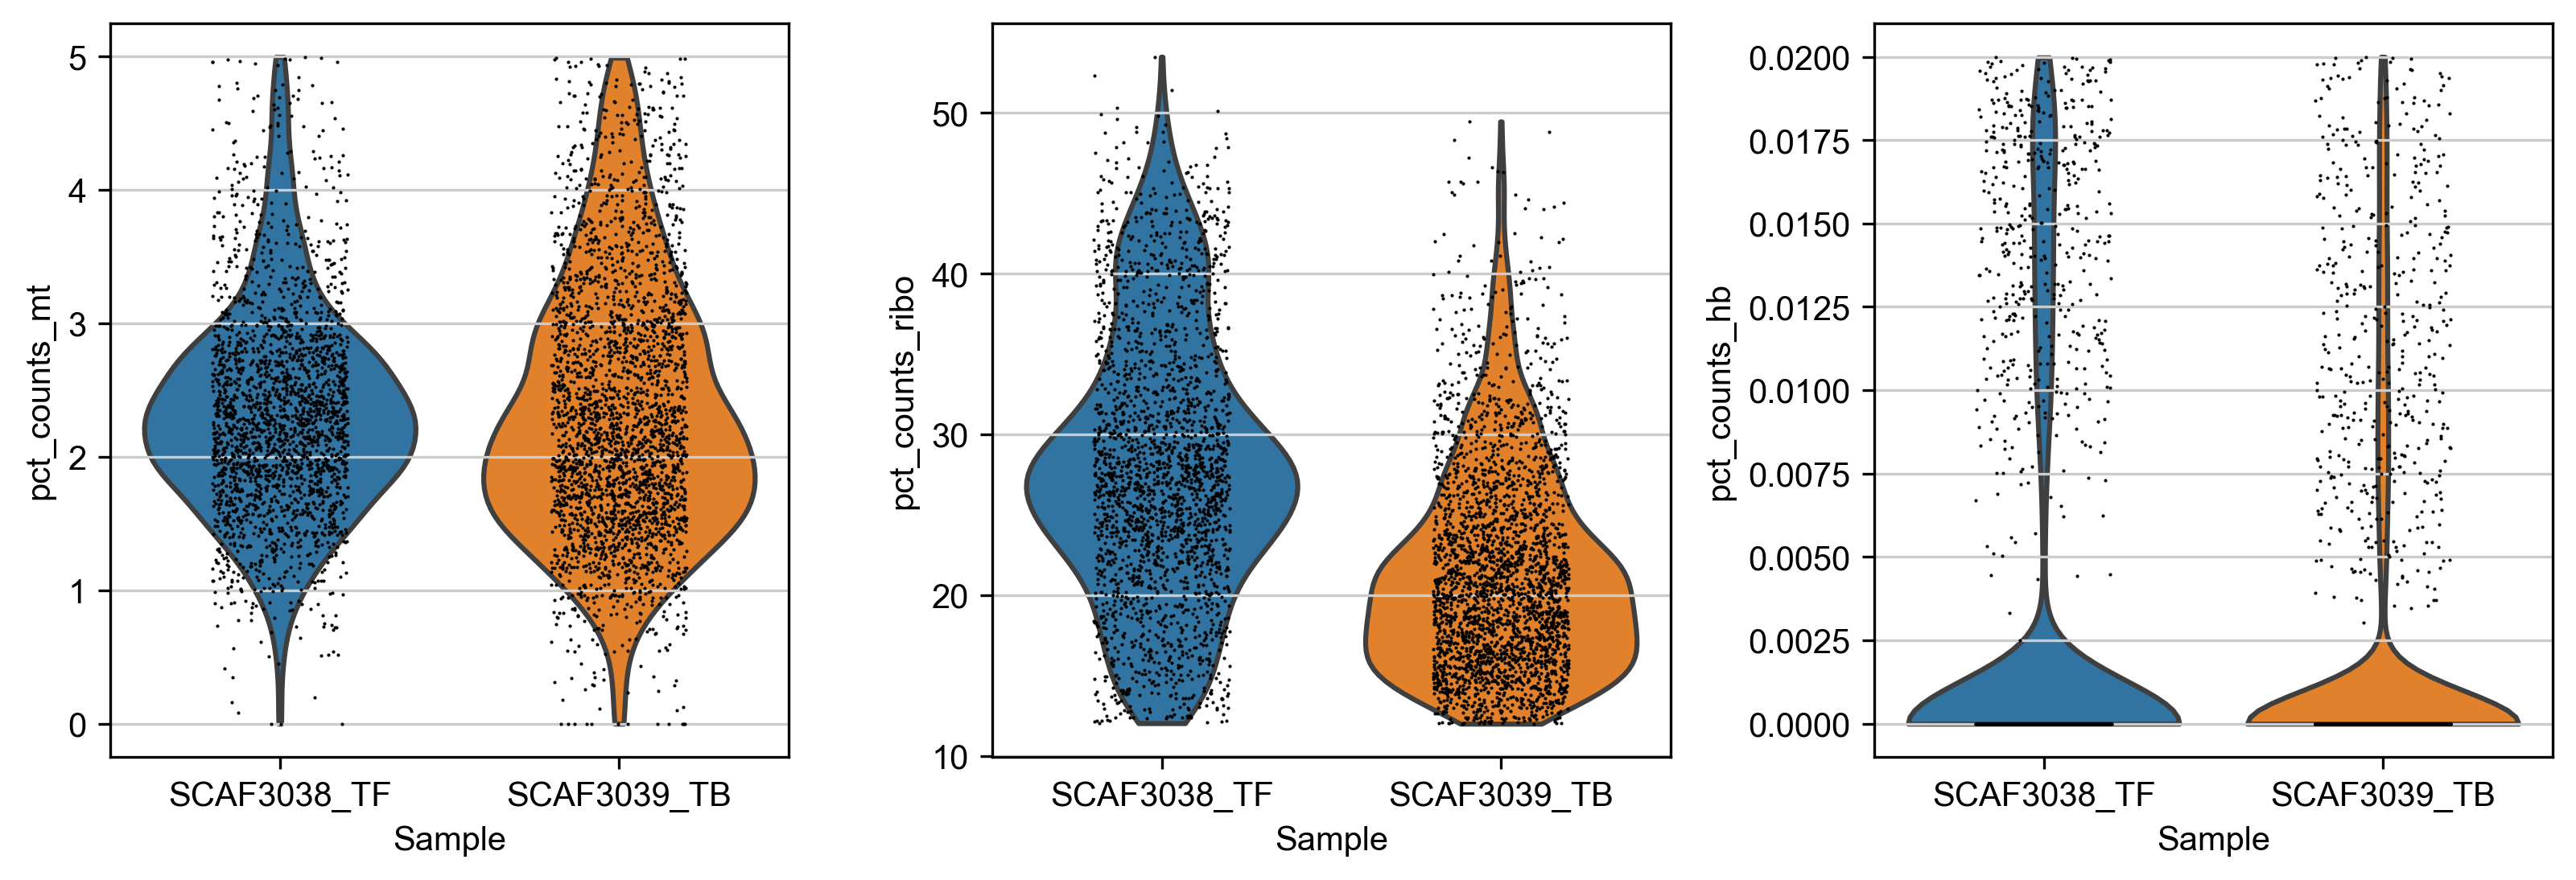

In [13]:
sc.pl.violin(adata, ['pct_counts_mt', "pct_counts_ribo", "pct_counts_hb"], groupby="Sample",
             jitter=0.2, multi_panel=True)

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


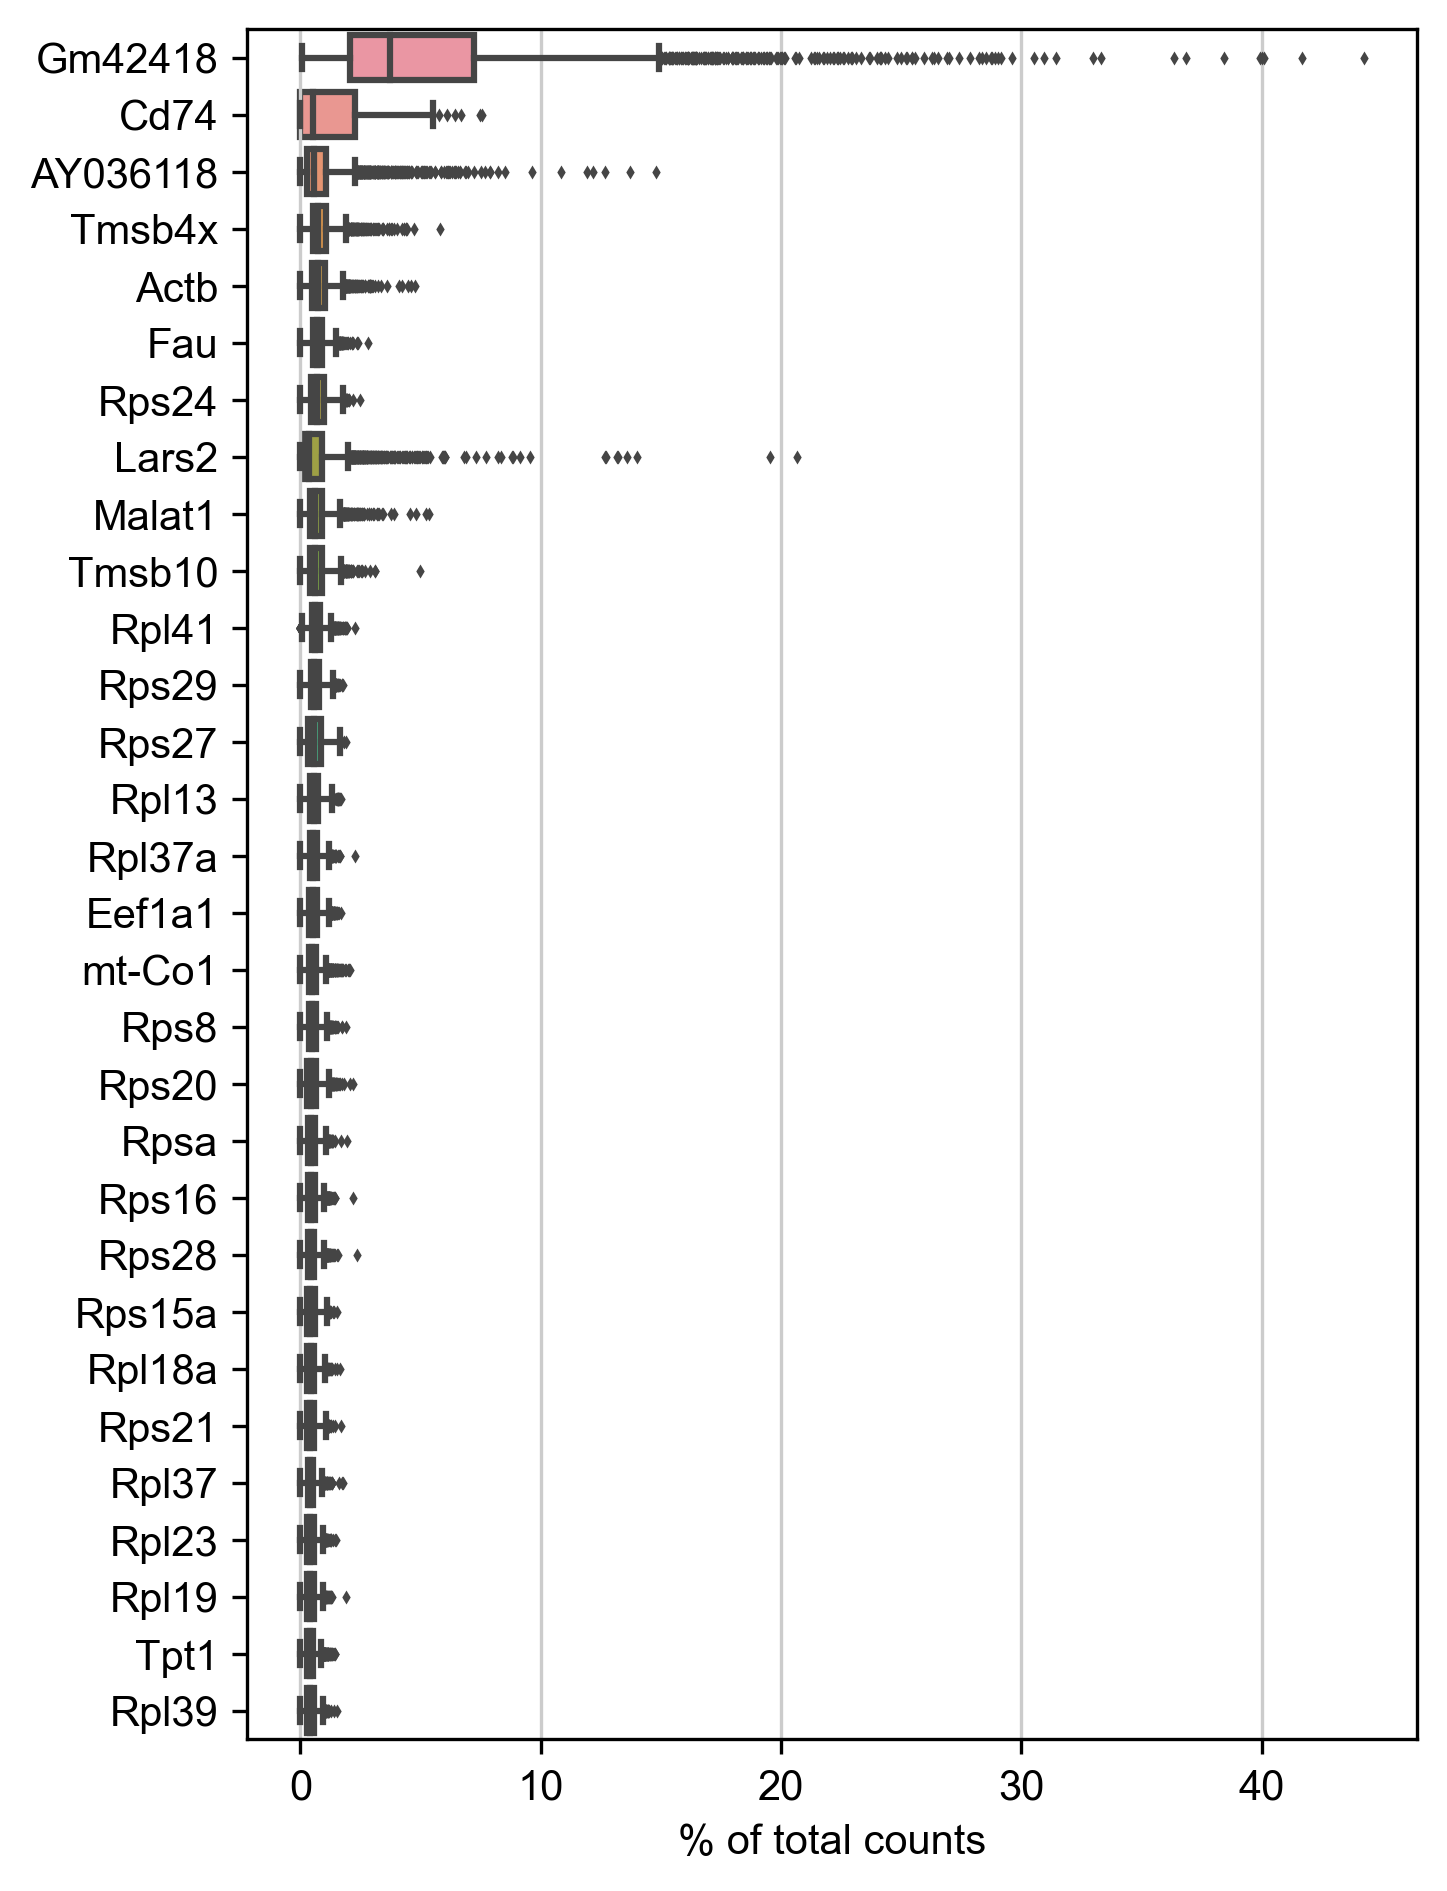

In [14]:
sc.pl.highest_expr_genes(adata, n_top=30, log=False)

## Specific gene removal

- Gm42418 (overlaps the rRNA element Rn45s and represent rRNA contamination, see https://doi.org/10.1038/s41467-021-27035-8)
- Malat1 (judged as mainly technical)
- mt genes (judged as mainly technical)

In [15]:
malat1 = adata.var_names.str.startswith("Malat1")
Gm42418 = adata.var_names.str.startswith("Gm42418")
AY036118 = adata.var_names.str.startswith("AY036118")

# we need to redefine the mito_genes since they were first
# calculated on the full object before removing low expressed genes.
mito_genes = adata.var_names.str.startswith("mt-")
ribo_genes = adata.var_names.str.contains(("^Rp[sl]"))
hb_genes = adata.var_names.str.contains(("^Hb[^(P)]"))

remove = np.add(mito_genes, malat1)
remove = np.add(remove, Gm42418)
remove = np.add(remove, AY036118)
remove = np.add(remove, ribo_genes)
remove = np.add(remove, hb_genes)
keep = np.invert(remove)

adata = adata[:, keep]

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


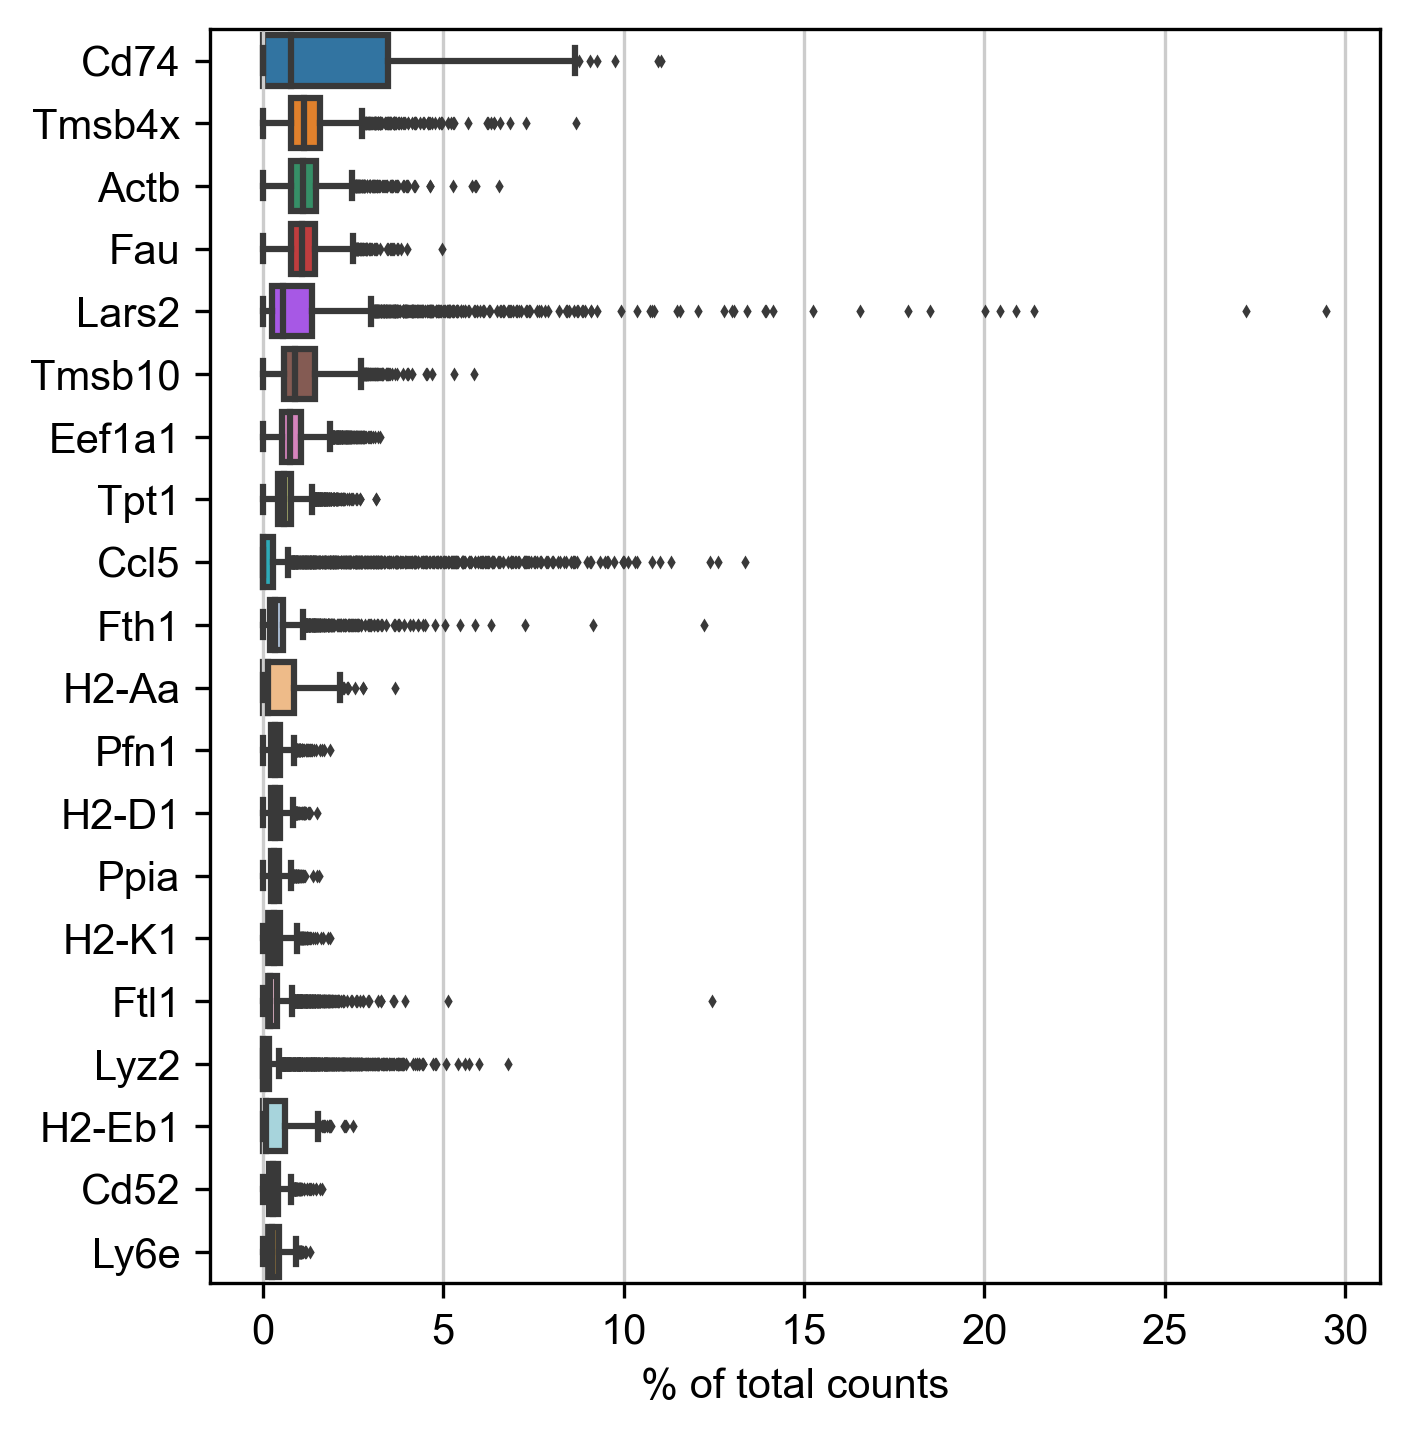

In [16]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [17]:
adata = adata[adata.obs.n_genes_by_counts < 3000, :]

In [18]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata)

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Normalize, Log1p, HVG
HVG is done by providing a key. Is this helpful?

In [19]:
sc.pp.scale(adata)

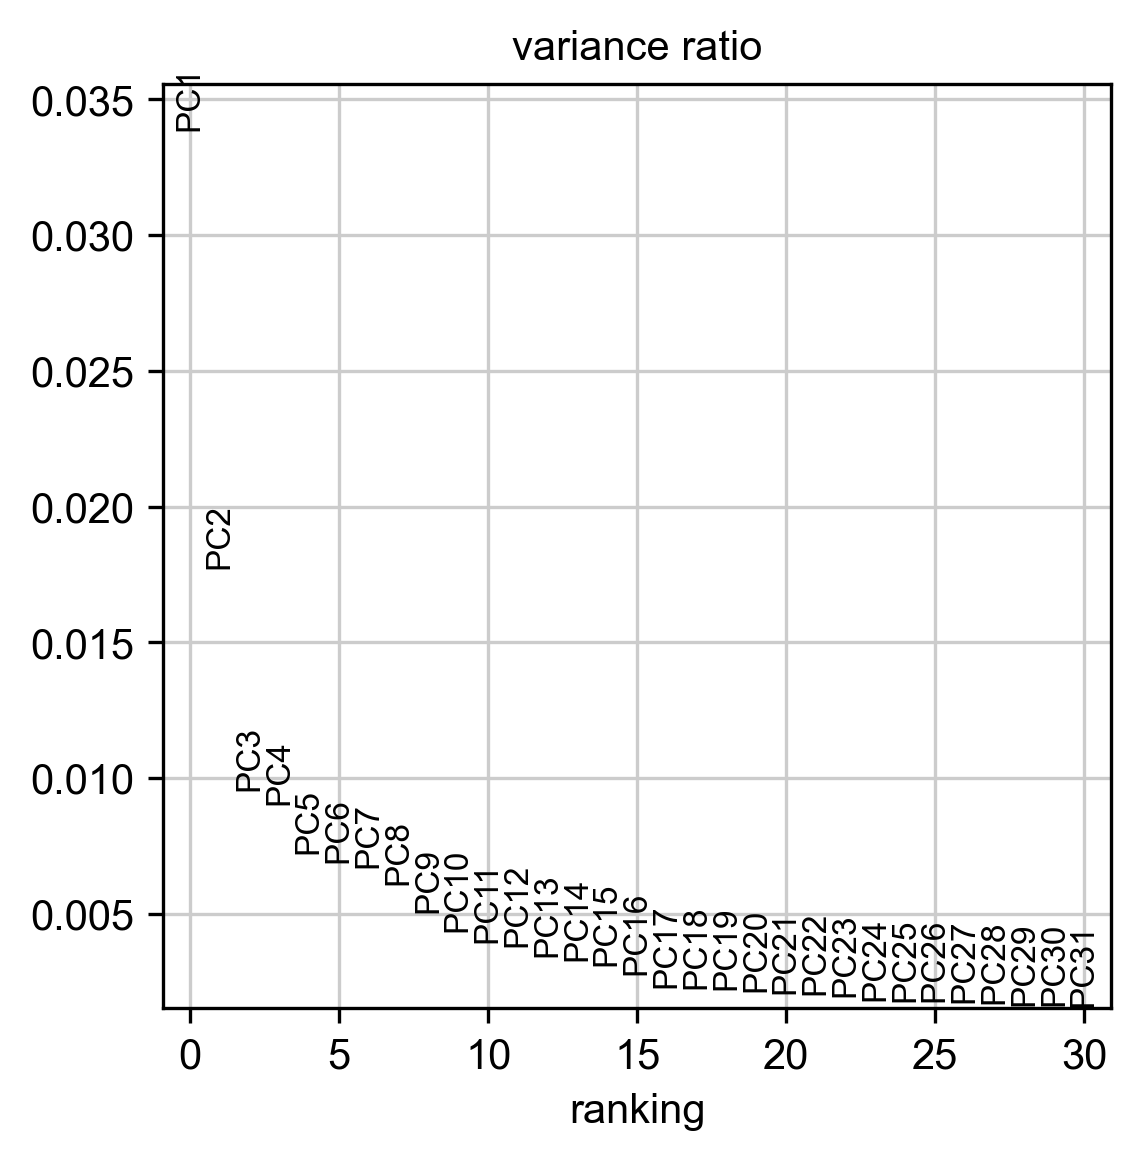

In [20]:
sc.pp.pca(adata, n_comps=50, use_highly_variable=True)
sc.pl.pca_variance_ratio(adata, n_pcs=30, log=False, show=None, save=None)

In [21]:
sce.pp.harmony_integrate(adata, "Sample", max_iter_harmony=50, adjusted_basis="X_pca")

2023-02-14 16:46:57,305 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-02-14 16:46:58,788 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-02-14 16:46:58,803 - harmonypy - INFO - Iteration 1 of 50
2023-02-14 16:46:59,521 - harmonypy - INFO - Iteration 2 of 50
2023-02-14 16:47:00,335 - harmonypy - INFO - Iteration 3 of 50
2023-02-14 16:47:01,061 - harmonypy - INFO - Iteration 4 of 50
2023-02-14 16:47:02,804 - harmonypy - INFO - Iteration 5 of 50
2023-02-14 16:47:04,879 - harmonypy - INFO - Iteration 6 of 50
2023-02-14 16:47:05,932 - harmonypy - INFO - Iteration 7 of 50
2023-02-14 16:47:06,745 - harmonypy - INFO - Iteration 8 of 50
2023-02-14 16:47:07,103 - harmonypy - INFO - Iteration 9 of 50
2023-02-14 16:47:07,751 - harmonypy - INFO - Iteration 10 of 50
2023-02-14 16:47:08,177 - harmonypy - INFO - Iteration 11 of 50
2023-02-14 16:47:08,773 - harmonypy - INFO - Iteration 12 of 50
2023-02-14 16:47:09,067 - harmonypy - INFO - Iteration 13 of

In [22]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=20, random_state=0)

In [23]:
sc.tl.umap(adata, random_state=0, a=0.05, b=2.2)

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


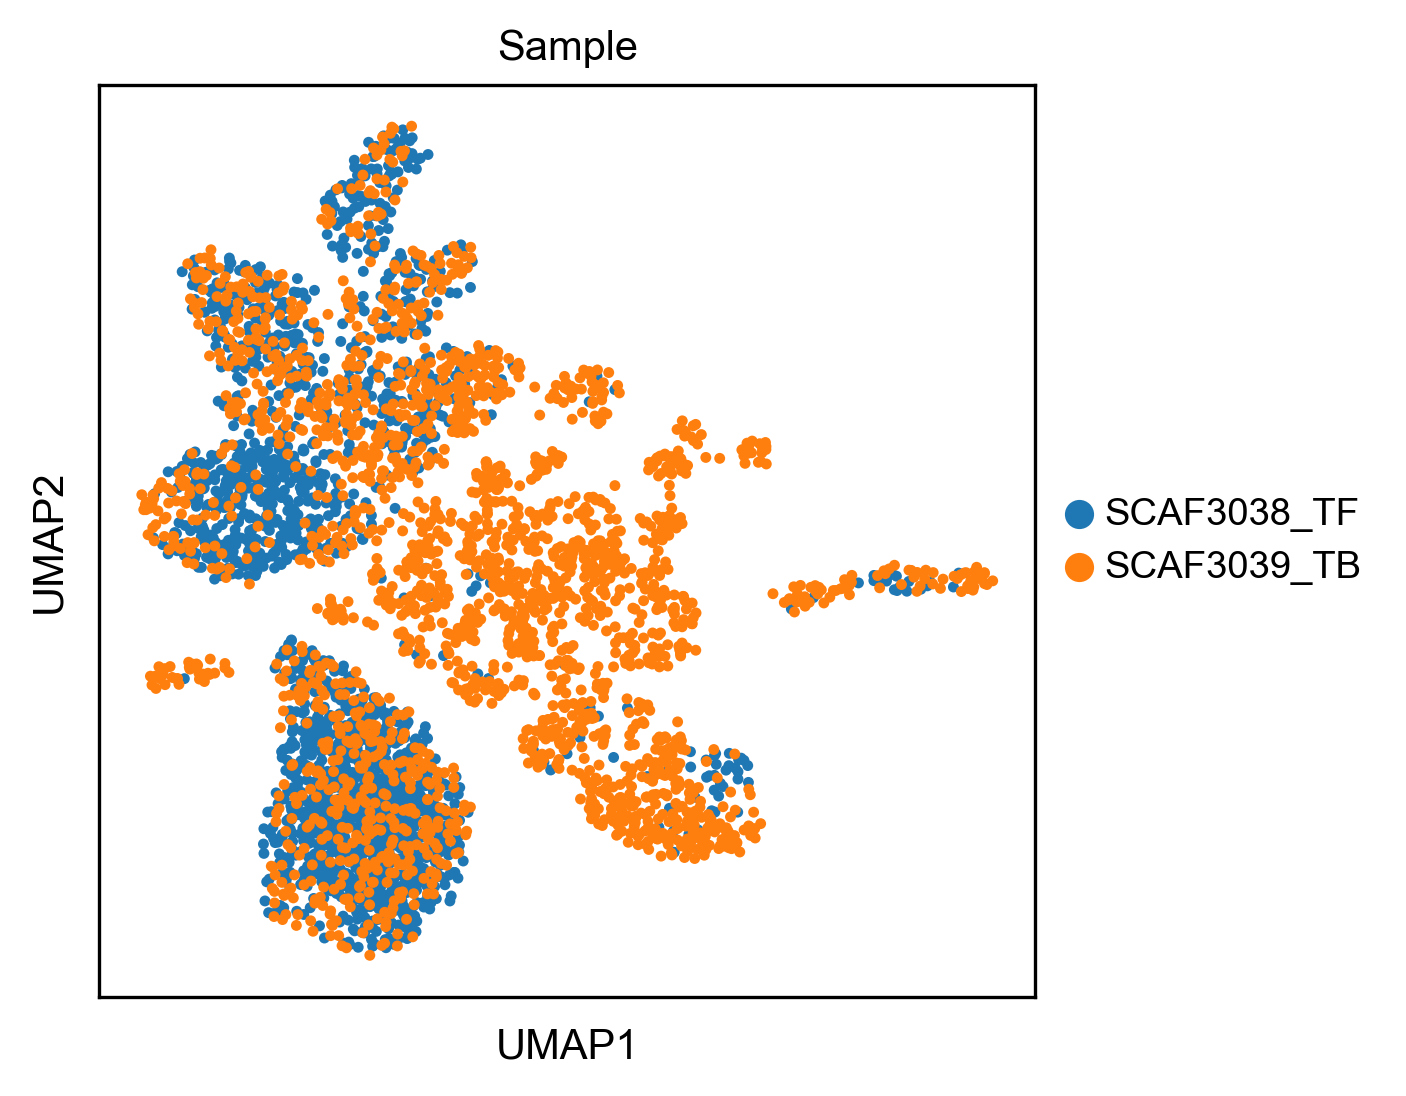

In [24]:
sc.pl.umap(adata, color="Sample", save="_Samples.pdf")

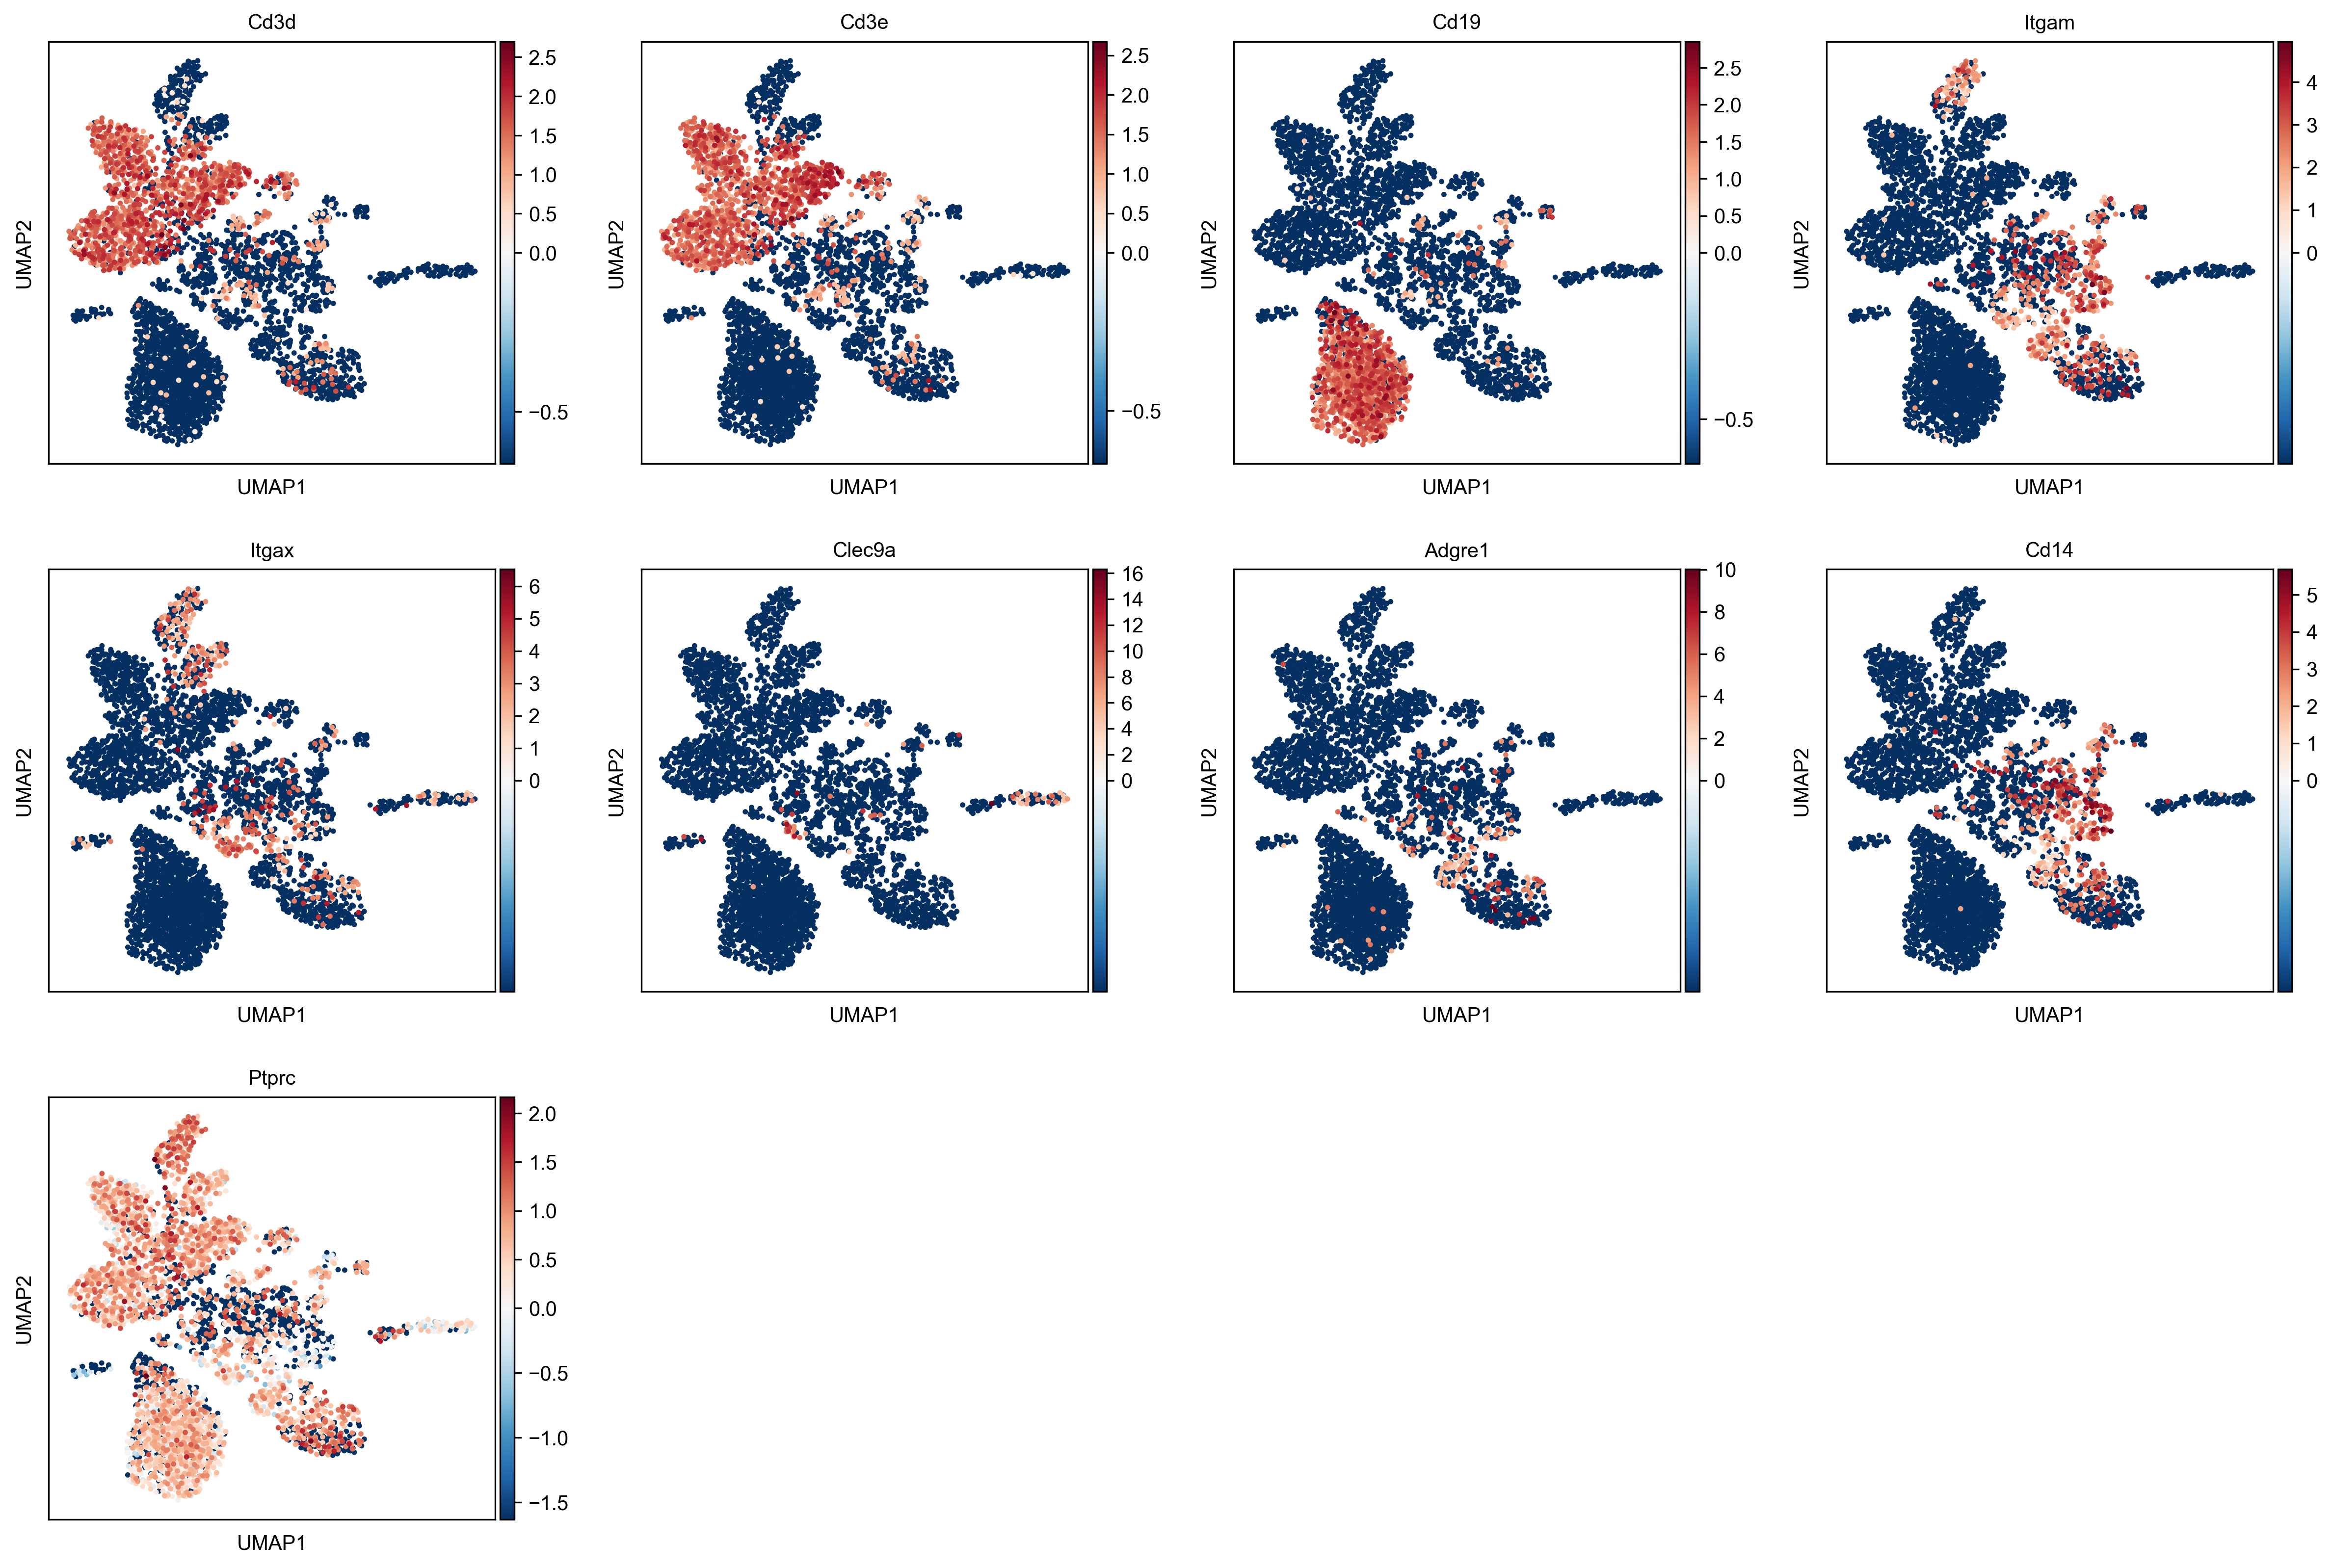

In [25]:
sc.pl.umap(adata, color=["Cd3d", "Cd3e","Cd19", "Itgam", "Itgax", "Clec9a", "Adgre1", "Cd14", "Ptprc"], use_raw=False, cmap="RdBu_r", vcenter=0, save="_CD45_Expression.pdf")

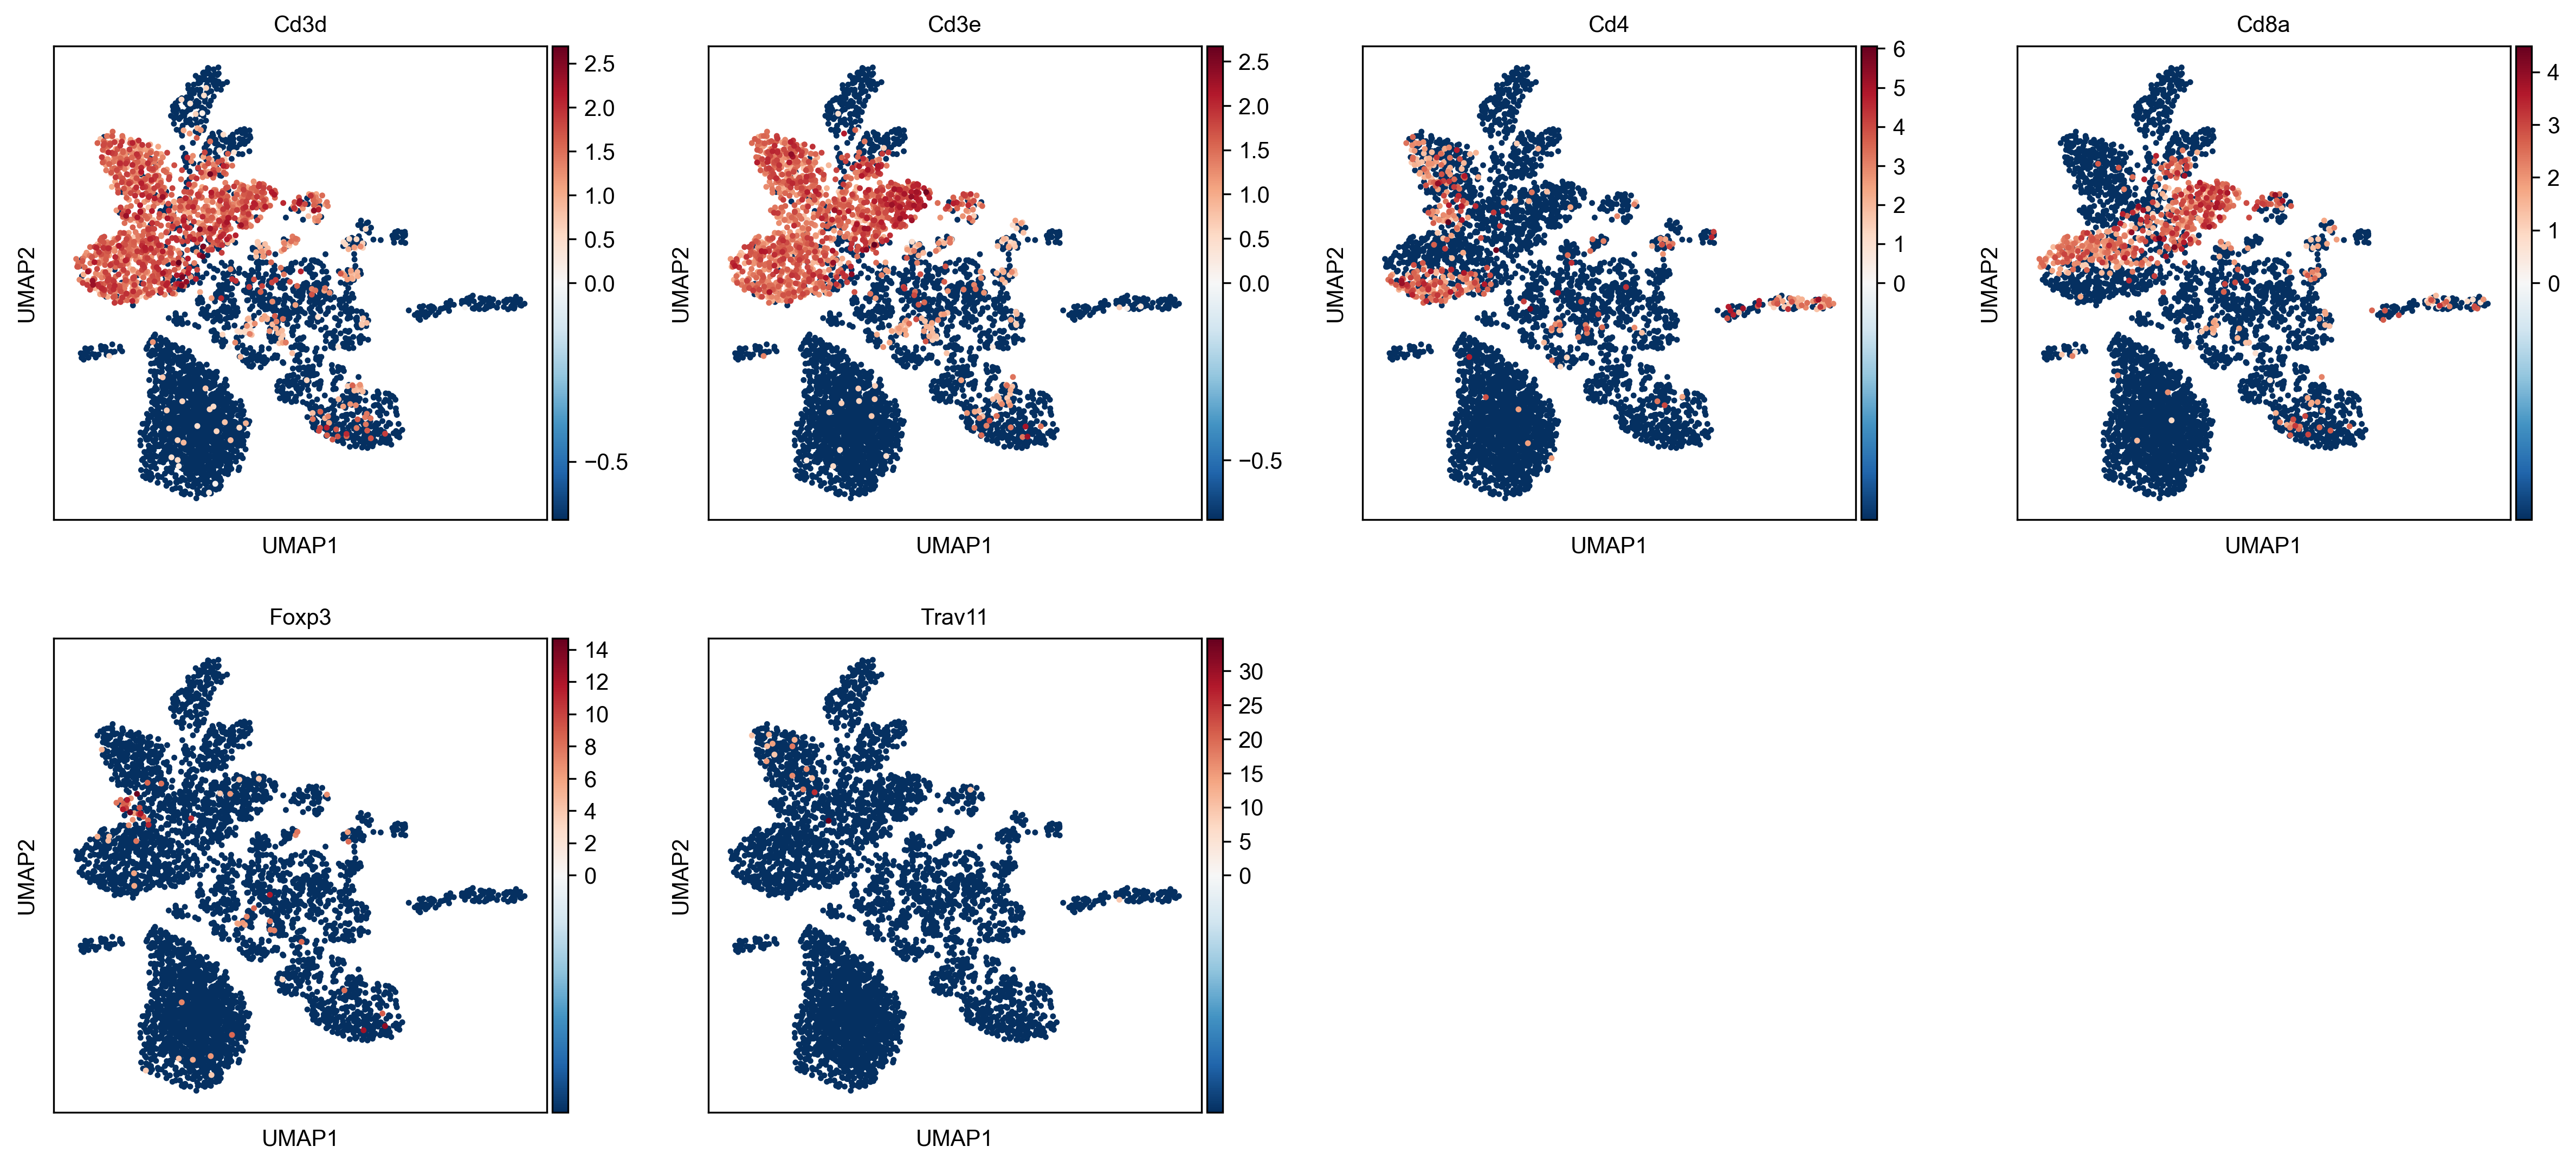

In [26]:
sc.pl.umap(adata, color=["Cd3d", "Cd3e", "Cd4", "Cd8a", "Foxp3", "Trav11" ], use_raw=False, cmap="RdBu_r", vcenter=0, save="_TCell_Expression.pdf")

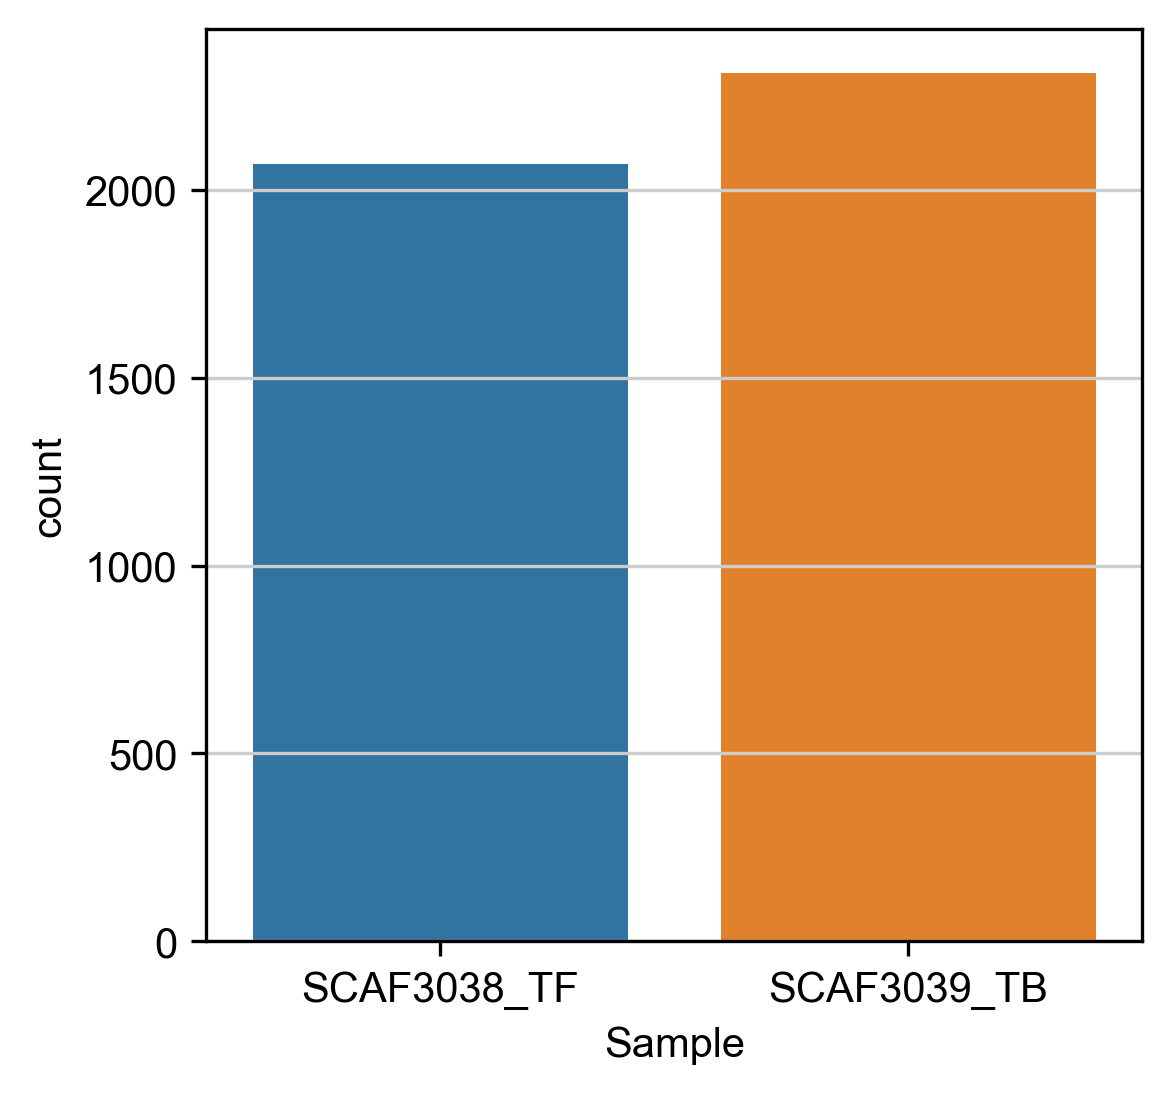

In [27]:
sns.countplot(x='Sample', data=adata.obs)
plt.show()

In [28]:
res_lst = [0.3, 0.4, 0.5]

for resolution in res_lst:
    sc.tl.leiden(adata, resolution=resolution, key_added=f"leiden_r{resolution}", random_state=0)

/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/matthias/miniconda3/envs/maitRev/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


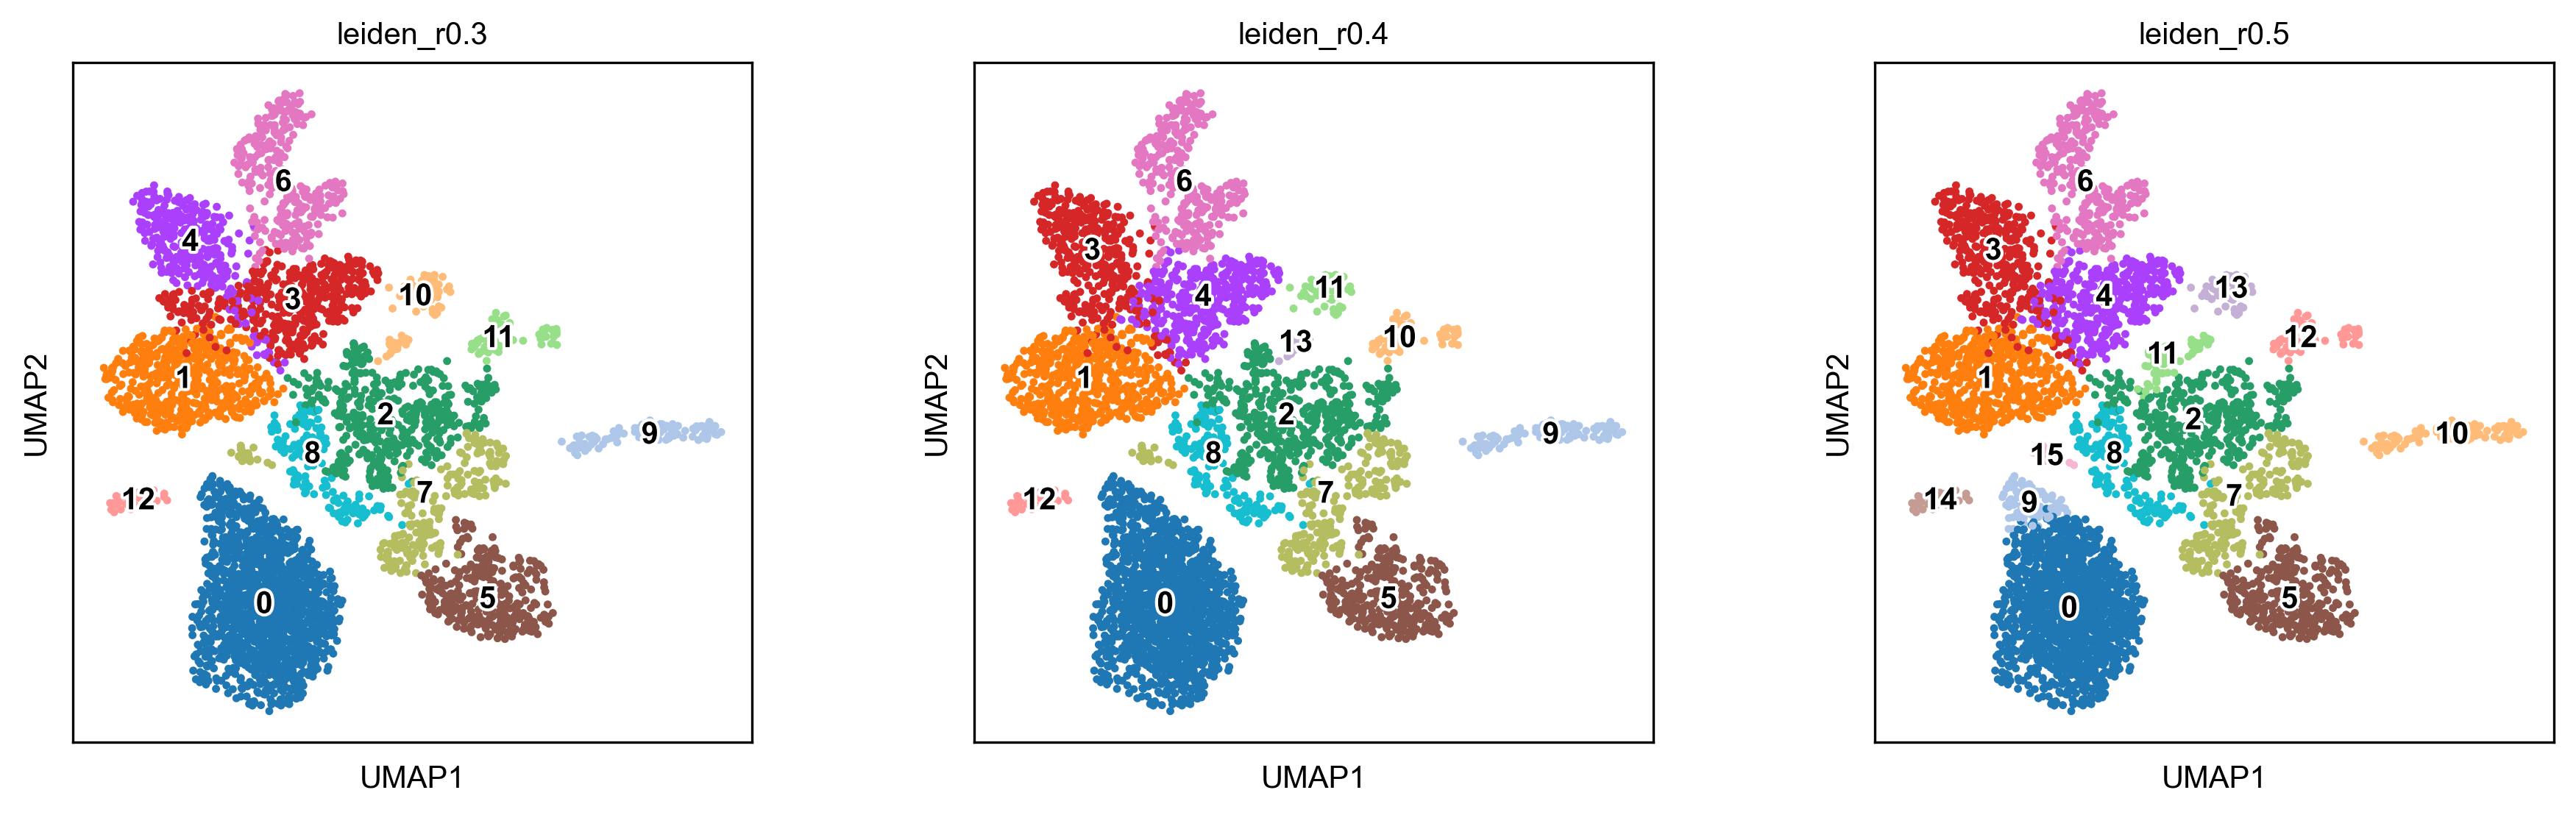

In [29]:
sc.pl.umap(adata, color=[f"leiden_r{r}" for r in res_lst], legend_loc="on data", legend_fontoutline=2, save="_Clusters.pdf")

In [30]:
for resolution in res_lst:
    with warnings.catch_warnings():
        warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
        sc.tl.rank_genes_groups(adata, f"leiden_r{resolution}", method='wilcoxon', use_raw=True, key_added=f"leiden_r{resolution}_wilcoxon")

        dedf_leiden = sc.get.rank_genes_groups_df(adata,group=None, key=f"leiden_r{resolution}_wilcoxon")
        dedf_leiden.drop("pvals", axis=1, inplace=True)
        dedf_leiden = dedf_leiden[dedf_leiden["pvals_adj"] < 0.05]

    with pd.ExcelWriter(f"scRNA-seq/Redone22/Manuscript/MurineModel//DGE/leiden_r{resolution}.xlsx") as writer:
        for cluster_id in dedf_leiden.group.unique():
            df_sub_cl = dedf_leiden[dedf_leiden.group == cluster_id].copy()
            df_sub_cl.to_excel(writer, sheet_name=f"c{cluster_id}")

    del df_sub_cl
    del dedf_leiden